In [1]:
import glob

import numpy             as np
import matplotlib.pyplot as plt

from CCfun  import in_range
from CCfun  import rebin
from CCfun  import filter_df
from CCfun  import longer_than_exwl
from CCfun  import compute_baseline_float

from CCplot import plot1d
from CCplot import plot_line
from CCplot import auto_plot_style
from CCplot import figure_sizes
from CCplot import subplots
from CCfit  import shifted_gauss
from CCfit  import fit

from CCdatabase import paper_signals
from CCdatabase import californication_irradiation_mapping

from CCio import load_all
from CCio import merge_measurements

In [2]:
%matplotlib inline

auto_plot_style()

In [3]:
%load_ext autoreload
%autoreload 2

# All data

In [4]:
filenames_pre  = glob.glob("/home/gonzalo/data/CC/Californication/*pre*.h5")
filenames_post = glob.glob("/home/gonzalo/data/CC/Californication/*post*.h5")
experiment     = load_all(filenames_pre, filenames_post)

In [5]:
experiment.pre.crystals.head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        7        2          0        1000    516       0.1   
1       False        7        2          0        1000    516       0.1   
2       False        7        2          0        1000    516       0.1   
3       False        7        2          0        1000    516       0.1   
4       False        7        2          0        1000    516       0.1   

   ex_wl     power   em_wl  counts crystal_id crystal_type  bkgsub   rate  \
0  275.0  0.000008  287.75    3228  Sp_B1_004           Sp   -58.0 -580.0   
1  275.0  0.000008  288.25    3232  Sp_B1_004           Sp   -54.0 -540.0   
2  275.0  0.000008  288.75    3211  Sp_B1_004           Sp   -75.0 -750.0   
3  275.0  0.000008  289.50    3222  Sp_B1_004           Sp   -64.0 -640.0   
4  275.0  0.000008  290.00    3209  Sp_B1_004           Sp   -77.0 -770.0   

        quantar       dquanta  wheel_no  
0  1.104294e+15 -5.252226e-13         0  
1  1.104294e+15 -4.890003e-13         0  
2  1.104294e+15 -6.791671e-13         0  
3  1.104294e+15 -5.795559e-13         0  
4  1.104294e+15 -6.972783e-13         0

In [6]:
experiment.post.crystals.head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        6        2          0        1000    114       0.1   
1       False        6        2          0        1000    114       0.1   
2       False        6        2          0        1000    114       0.1   
3       False        6        2          0        1000    114       0.1   
4       False        6        2          0        1000    114       0.1   

   ex_wl     power   em_wl  counts crystal_id crystal_type  bkgsub    rate  \
0  275.0  0.000008  287.75    3155  Sp_B2_038           Sp  -134.0 -1340.0   
1  275.0  0.000008  288.25    3145  Sp_B2_038           Sp  -144.0 -1440.0   
2  275.0  0.000008  288.75    3149  Sp_B2_038           Sp  -140.0 -1400.0   
3  275.0  0.000008  289.50    3123  Sp_B2_038           Sp  -166.0 -1660.0   
4  275.0  0.000008  290.00    3122  Sp_B2_038           Sp  -167.0 -1670.0   

        quantar       dquanta  wheel_no  
0  1.081312e+15 -1.239235e-12         3  
1  1.081312e+15 -1.331716e-12         3  
2  1.081312e+15 -1.294723e-12         3  
3  1.081312e+15 -1.535172e-12         3  
4  1.081312e+15 -1.544420e-12         3

In [7]:
def f64(*args):
    return np.array(list(map(np.float64, args)))

In [8]:
def fit_prepost(crystal_type, ex_wl, peak, xrange=None, rebin_by=1, window=125, **overrides):
    grating = 1 + int(ex_wl >= 400)
    expi    = 1 if overrides.get("exposure", 10) == 10 else 4

    selections_pre  = dict(crystal_type = crystal_type,
                           ex_wl        =        ex_wl,
                           exposure     =           10,
                           exp_index    =         expi,
                           grating      =      grating,
                           slit_width   =         1000,
                           looparound   =         True)

    selections_post = dict(crystal_type = crystal_type,
                           ex_wl        =        ex_wl,
                           exposure     =           10,
                           exp_index    =            0,
                           grating      =      grating,
                           slit_width   =         1000,
                           looparound   =        False)
    selections_pre .update(overrides)
    selections_post.update(overrides)

    gb_pre   = filter_df(experiment.pre .crystals, selections_pre ).groupby("crystal_id")
    gb_post  = filter_df(experiment.post.crystals, selections_post).groupby("crystal_id")
    crystals = set(list(gb_pre.groups.keys()) + list(gb_post.groups.keys()))
    n        = len(crystals)

    plt.figure(figsize=figure_sizes[n])
    for k, crystal_id in enumerate(crystals, start=1):
        pre  = gb_pre .get_group(crystal_id)
        post = gb_post.get_group(crystal_id)

        assert len(pre ) == 1600, (len(pre ), 1600)
        assert len(post) == 1600, (len(post), 1600)

        pre  = longer_than_exwl(pre , delta=5)
        post = longer_than_exwl(post, delta=5)
        
        plt.subplot(*subplots[n], k)

        x  = pre.em_wl  .values
        y  = pre.dquanta.values
        y -= compute_baseline_float(y)
        if rebin_by > 1:
            x = rebin(x, rebin_by, np.mean)
            y = rebin(y, rebin_by, np.sum )
        m  = in_range(x, peak - window, peak + window)
        xf = x[m]
        yf = y[m]
        s  = np.abs(yf).max(), peak     ,  30,  0    
        f  = fit(shifted_gauss, xf, yf, s, maxfev=int(1e6))
        
        plot1d(x, y, 
               label  = "pre")
        plot1d(xf, f.fn(xf),
               color  = "r",
               label  = "fit",
               ylabel = "ph/ph/s"    ,
               title  = crystal_id + " " + californication_irradiation_mapping[crystal_id])
        
        print(k, crystal_id, "pre ", "int", f.values[0] / np.diff(x)[0] / 1e-13, "peak", f.fn(f.values[1]) / 1e-13)

        x  = post.em_wl  .values
        y  = post.dquanta.values
        y -= compute_baseline_float(y)
        if rebin_by > 1:
            x = rebin(x, rebin_by, np.mean)
            y = rebin(y, rebin_by, np.sum )
        m  = in_range(x, peak - window, peak + window)
        xf = x[m]
        yf = y[m]
        s  = np.abs(yf).max(), peak     ,  30,  0    
        f  = fit(shifted_gauss, xf, yf, s, maxfev=int(1e6))
        
        plot1d(x, y, 
               label  = "post")
        plot1d(xf, f.fn(xf),
               color  = "r",
               label  = "fit",
               ylabel = "ph/ph/s"    ,
               title  = crystal_id + " " + californication_irradiation_mapping[crystal_id])
        
        print(k, crystal_id, "post", "int", f.values[0] / np.diff(x)[0] / 1e-13, "peak", f.fn(f.values[1]) / 1e-13)

        if xrange is not None:
            plt.xlim(*xrange)

        plt.legend()
    plt.tight_layout()
    
def fit_diff(crystal_type, ex_wl, peak, xrange=None, rebin_by=1, window=125, **overrides):
    grating = 1 + int(ex_wl >= 400)
    expi    = 1 if overrides.get("exposure", 10) == 10 else 4
    selections_pre  = dict(crystal_type = crystal_type,
                           ex_wl        =        ex_wl,
                           exposure     =           10,
                           exp_index    =         expi,
                           grating      =      grating,
                           slit_width   =         1000,
                           looparound   =         True)

    selections_post = dict(crystal_type = crystal_type,
                           ex_wl        =        ex_wl,
                           exposure     =           10,
                           exp_index    =            0,
                           grating      =      grating,
                           slit_width   =         1000,
                           looparound   =        False)
    selections_pre .update(overrides)
    selections_post.update(overrides)

    gb_pre   = filter_df(experiment.pre .crystals, selections_pre ).groupby("crystal_id")
    gb_post  = filter_df(experiment.post.crystals, selections_post).groupby("crystal_id")
    crystals = set(list(gb_pre.groups.keys()) + list(gb_post.groups.keys()))
    n        = len(crystals)

    plt.figure(figsize=figure_sizes[n])
    for k, crystal_id in enumerate(crystals, start=1):
        pre  = gb_pre .get_group(crystal_id)
        post = gb_post.get_group(crystal_id)

        assert len(pre ) == 1600, (len(pre ), 1600)
        assert len(post) == 1600, (len(post), 1600)

        pre  = longer_than_exwl(pre , delta=5)
        post = longer_than_exwl(post, delta=5)
        
        x  = post.em_wl  .values
        y  = post.dquanta.values - pre.dquanta.values
        y -= compute_baseline_float(y)
        if rebin_by > 1:
            x = rebin(x, rebin_by, np.mean)
            y = rebin(y, rebin_by, np.sum )
        m  = in_range(x, peak - window, peak + window)
        xf = x[m]
        yf = y[m]
        s  = np.abs(yf).max(), peak     ,  30,  0    
        f  = fit(shifted_gauss, xf, yf, s, maxfev=int(1e6))
        
        plt.subplot(*subplots[n], k)
        plot1d(x, y, 
               label  = "post - pre")
        plot1d(xf, f.fn(xf),
               color  = "r",
               label  = "fit",
               ylabel = "ph/ph/s"    ,
               title  = crystal_id + " " + californication_irradiation_mapping[crystal_id])
        
        print(k, crystal_id, "diff", "int", f.values[0] / np.diff(x)[0] / 1e-13, "peak", f.fn(f.values[1]) / 1e-13)
        if xrange is not None:
            plt.xlim(*xrange)

        if crystal_id == "Sp_B2_038":
            plt.ylim(-5e-14 * rebin_by, 1e-13 * rebin_by)
        plt.legend()
    plt.tight_layout()

In [9]:
data = experiment.pre.crystals
data[data.looparound].exp_index.drop_duplicates()

307200    0
312000    1
313600    2
315200    3
316800    4
Name: exp_index, dtype: int64

In [10]:
experiment.pre.crystals.crystal_id.drop_duplicates()

0            Sp_B1_004
345600       Qz_B2_078
691200       Qz_B2_079
1036800     CaF_B1_292
2073600     BaF_B1_174
2841600     CaF_B1_281
3878400     CaF_B1_282
4915200     CaF_B1_289
5952000     CaF_B1_290
6988800     BaF_B1_170
7756800     BaF_B1_171
8524800     BaF_B1_172
9292800     BaF_B1_173
10060800     Sp_B2_036
10406400     Sp_B2_037
10752000     Sp_B2_038
11097600     Sp_B2_039
11443200     Qz_B2_073
11788800     Qz_B2_074
12134400     Qz_B2_076
12480000     Qz_B2_077
Name: crystal_id, dtype: object

In [11]:
experiment.post.crystals.crystal_id.drop_duplicates()

0            Sp_B2_038
345600       Sp_B1_004
691200       Qz_B2_076
1036800      Qz_B2_078
1382400      Qz_B2_079
1728000     CaF_B1_289
2764800     CaF_B1_292
3801600     BaF_B1_172
4569600     BaF_B1_174
5337600     CaF_B1_281
6374400     CaF_B1_282
7411200     CaF_B1_290
8448000     BaF_B1_170
9216000     BaF_B1_171
9984000     BaF_B1_173
10752000     Sp_B2_036
11097600     Sp_B2_037
11443200     Sp_B2_039
11788800     Qz_B2_073
12134400     Qz_B2_074
12480000     Qz_B2_077
Name: crystal_id, dtype: object

# Sp

1 Sp_B1_004 pre  int -76.01970044362604 peak -0.4210122262388179
1 Sp_B1_004 post int -18.01436631379057 peak -0.07559636501062472
2 Sp_B2_039 pre  int 4708.434718579149 peak 183.2557637504523
2 Sp_B2_039 post int 4067.263394921777 peak 158.0957352426253
3 Sp_B2_037 pre  int 8.764507828524312 peak 0.34189418896775337
3 Sp_B2_037 post int 5.758022543096419 peak 0.22613704828759684
4 Sp_B2_038 pre  int 306.4467880331515 peak 11.883863894581566
4 Sp_B2_038 post int 288.38972115394415 peak 11.250379697884435
5 Sp_B2_036 pre  int 41.48977042442116 peak 4.186875200941619
5 Sp_B2_036 post int 13.34479277548935 peak 0.4597466667693736


/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1 Sp_B1_004 diff int 1.3038966879537084 peak 0.07025175944256458
2 Sp_B2_039 diff int -640.8652105092693 peak -25.413014235826797
3 Sp_B2_037 diff int -1.7914699642908507 peak -0.03144297729627327
4 Sp_B2_038 diff int -18.222576044370175 peak -0.6502303102048761
5 Sp_B2_036 diff int 17.397939842622744 peak 0.896625300481007


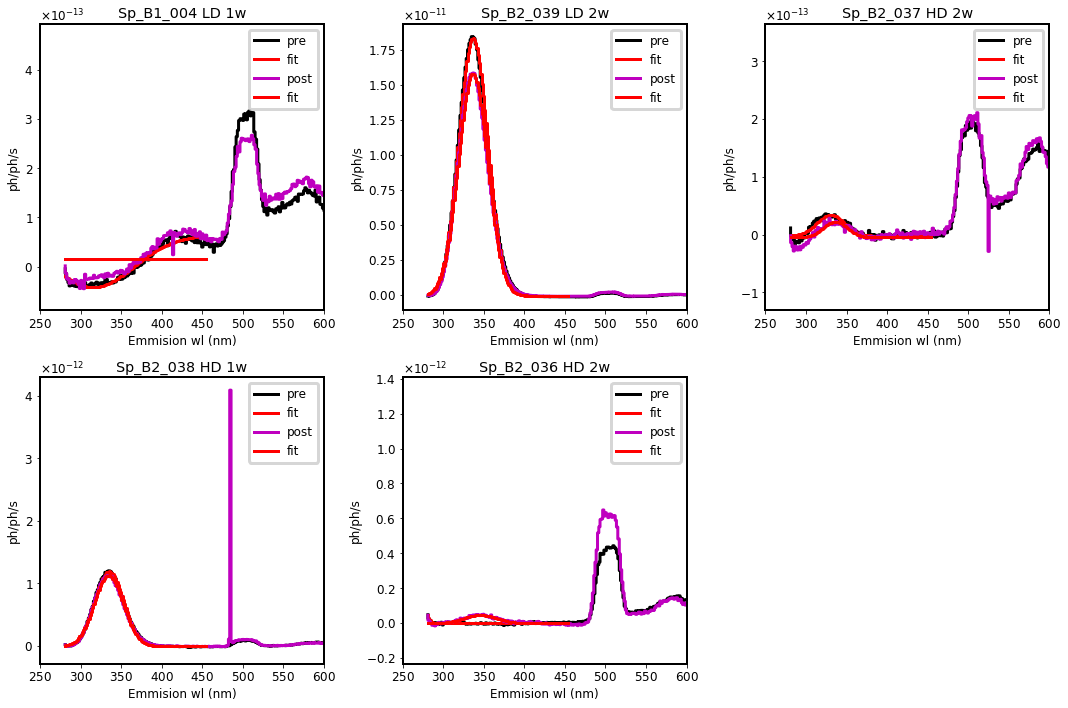

In [12]:
fit_prepost("Sp", ex_wl=250, peak=330, xrange=(250, 600), rebin_by=3)
fit_diff   ("Sp", ex_wl=250, peak=330, xrange=(250, 600), rebin_by=3)

# CaF

1 CaF_B1_289 pre  int 9.854600522215813 peak 0.28955034660123147
1 CaF_B1_289 post int 39.04797942718105 peak 0.8512918895320903
2 CaF_B1_282 pre  int 17.86862826242127 peak 0.20628300660465185
2 CaF_B1_282 post int 17.06271132057461 peak 0.1887949373784331
3 CaF_B1_281 pre  int 41.7779617151749 peak 0.6376520845353583
3 CaF_B1_281 post int 23.417471812903916 peak 0.30387377135452215
4 CaF_B1_290 pre  int 22.593500762531807 peak 0.594596804887142
4 CaF_B1_290 post int 25.808276312750113 peak 0.5974830477536017
5 CaF_B1_292 pre  int 24.940267388523353 peak 0.4433447593607701
5 CaF_B1_292 post int 39.86094992850651 peak 0.7512224557116151
1 CaF_B1_289 diff int 53.31646214136708 peak 0.6132063707127154
2 CaF_B1_282 diff int -1892.300338198968 peak -0.12537466487857823
3 CaF_B1_281 diff int -19.080417877711927 peak -0.4487809665267633
4 CaF_B1_290 diff int 3.388054322468126 peak 0.05949999525276985
5 CaF_B1_292 diff int 15.324651680164875 peak 0.4169163015126154


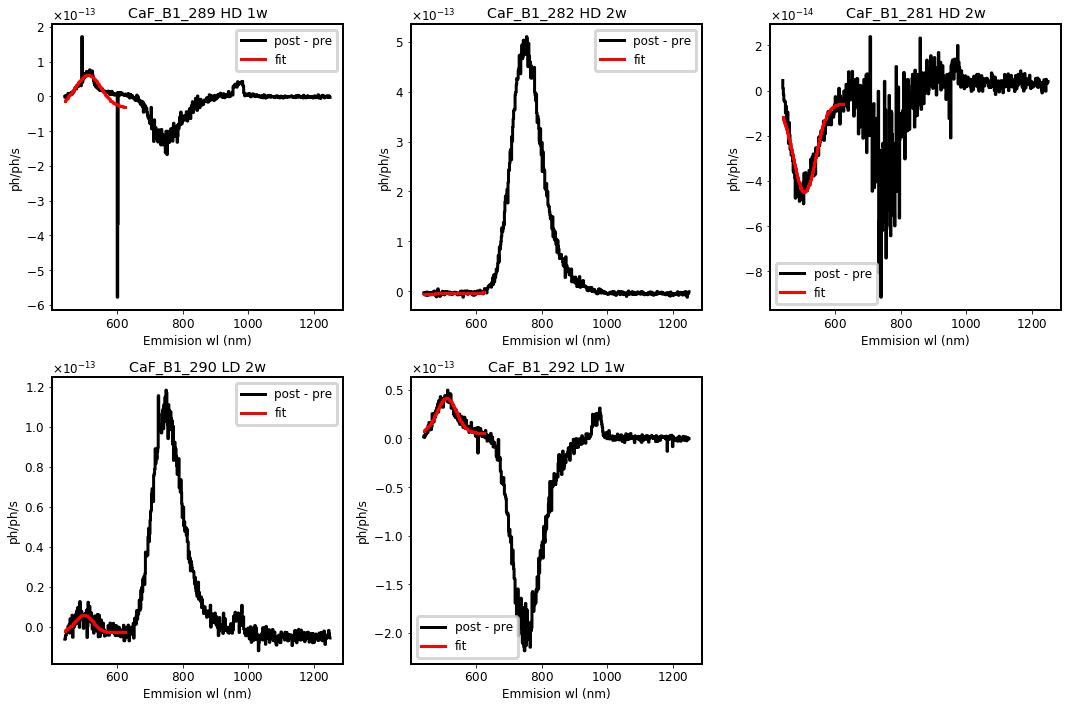

In [13]:
fit_prepost("CaF", ex_wl=410, peak=500, rebin_by=3)
fit_diff   ("CaF", ex_wl=410, peak=500, rebin_by=3)

1 CaF_B1_289 pre  int 1612.4706915071863 peak 26.05299439980747
1 CaF_B1_289 post int 1544.860427186094 peak 24.670598300907546
2 CaF_B1_282 pre  int 1489.7729714899285 peak 23.850050140315197
2 CaF_B1_282 post int 1794.3313496301723 peak 28.755707001220088
3 CaF_B1_281 pre  int 1530.293495772853 peak 24.401578519887625
3 CaF_B1_281 post int 1509.821140485809 peak 24.100215385456035
4 CaF_B1_290 pre  int 34.22326934425448 peak 0.6171367881618105
4 CaF_B1_290 post int 102.36839386711283 peak 1.6588849189570651
5 CaF_B1_292 pre  int 789.0749616687174 peak 12.609322935505643
5 CaF_B1_292 post int 662.2212657449683 peak 10.48815964616394
1 CaF_B1_289 diff int -68.80752496961257 peak -1.26663191918004
2 CaF_B1_282 diff int 304.5838667120389 peak 4.887817296679921
3 CaF_B1_281 diff int -21.102223883316363 peak -0.427860258214374
4 CaF_B1_290 diff int 68.27461784979725 peak 1.0866895420361407
5 CaF_B1_292 diff int -126.9481675670176 peak -2.014906457383512


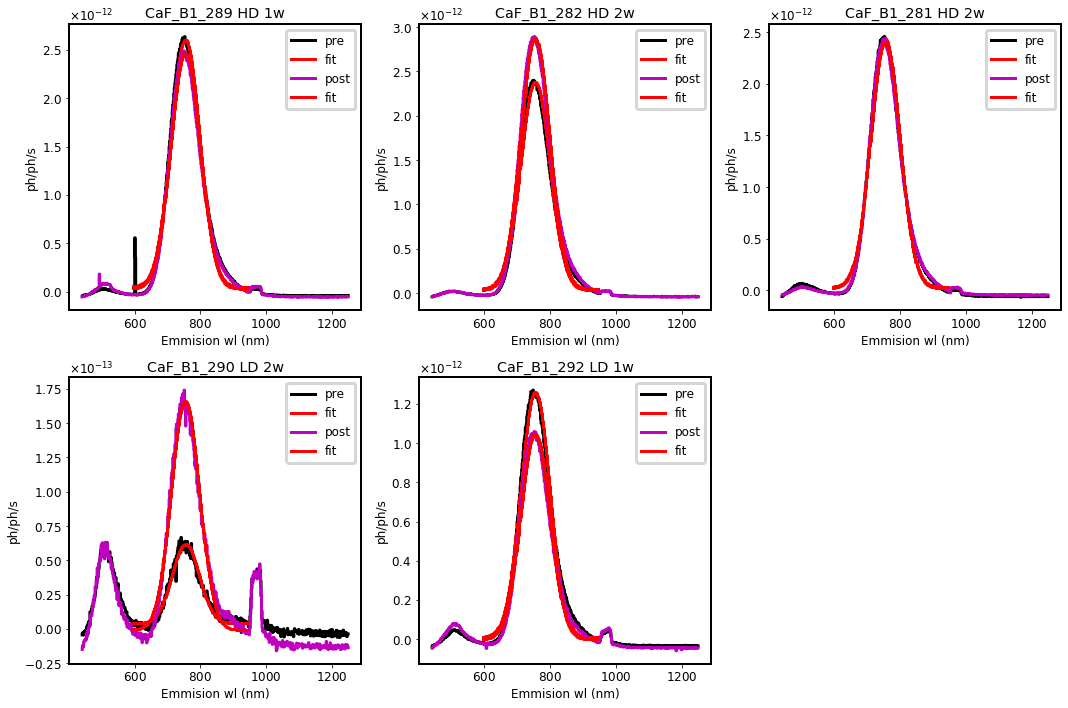

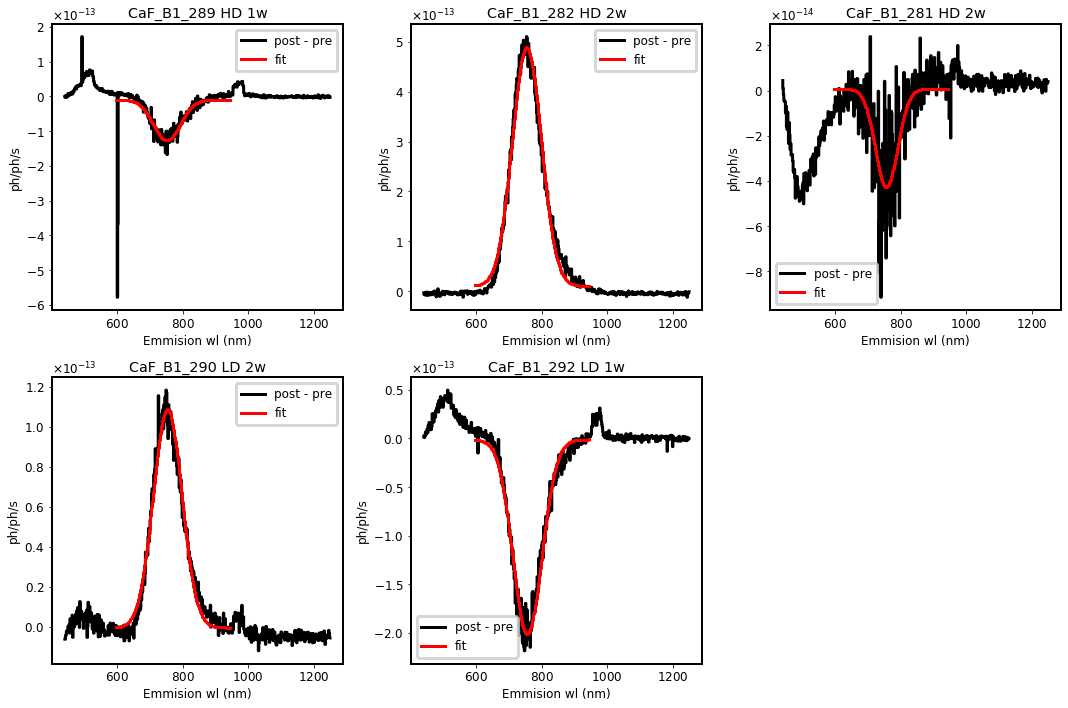

In [14]:
fit_prepost("CaF", ex_wl=410, peak=770, window=175, rebin_by=3)
fit_diff   ("CaF", ex_wl=410, peak=770, window=175, rebin_by=3)

1 CaF_B1_289 pre  int 124.6140462963448 peak 2.810178949190399
1 CaF_B1_289 post int 146.53254776473926 peak 3.6167865084502684
2 CaF_B1_282 pre  int 85.16346099833609 peak 1.7750702741310262
2 CaF_B1_282 post int 83.8497696805371 peak 1.796923550936358
3 CaF_B1_281 pre  int 127.89890284760023 peak 2.7135547874304167
3 CaF_B1_281 post int 106.42306238892992 peak 2.255456873602605
4 CaF_B1_290 pre  int 160.2925126449761 peak 4.239615028897741
4 CaF_B1_290 post int 164.8256184452885 peak 4.25487947432944
5 CaF_B1_292 pre  int 150.73325099594624 peak 3.8345905279572614
5 CaF_B1_292 post int 166.84540861635855 peak 4.052538746272517
1 CaF_B1_289 diff int 22.070660536718826 peak 0.9881700314845899
2 CaF_B1_282 diff int -5.241815576253963 peak -0.07238210025006932
3 CaF_B1_281 diff int -24.082132652916837 peak -0.4121764491100607
4 CaF_B1_290 diff int 3.7224942215127808 peak 0.06494167523549492
5 CaF_B1_292 diff int 26.742162747718584 peak 0.33789769276225146


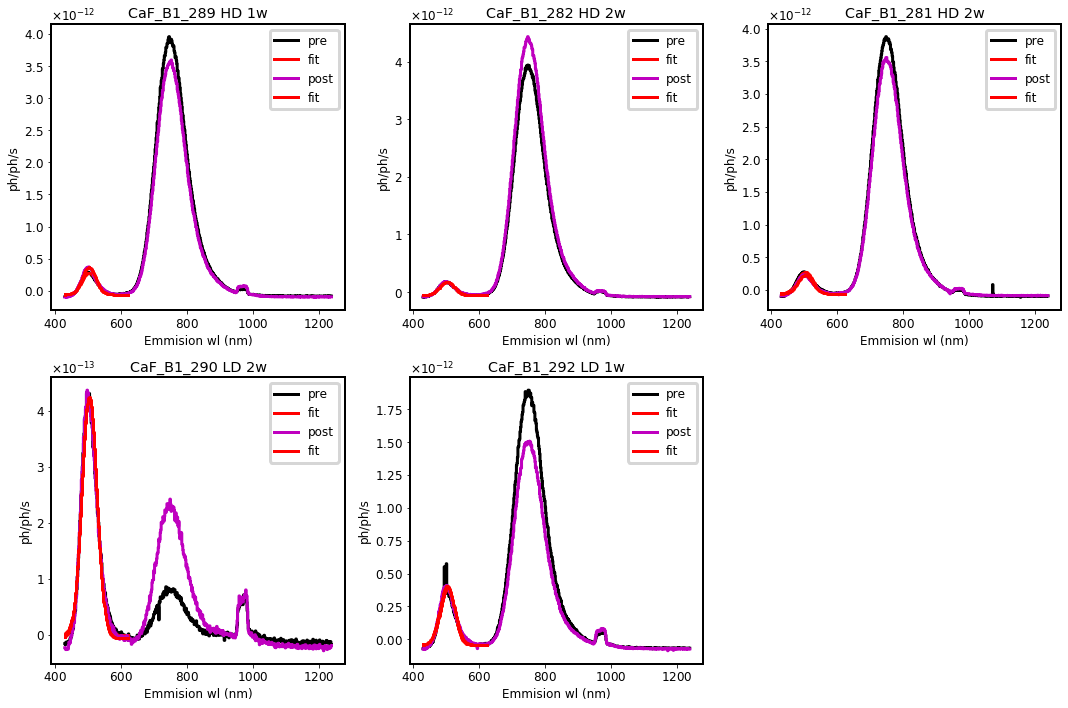

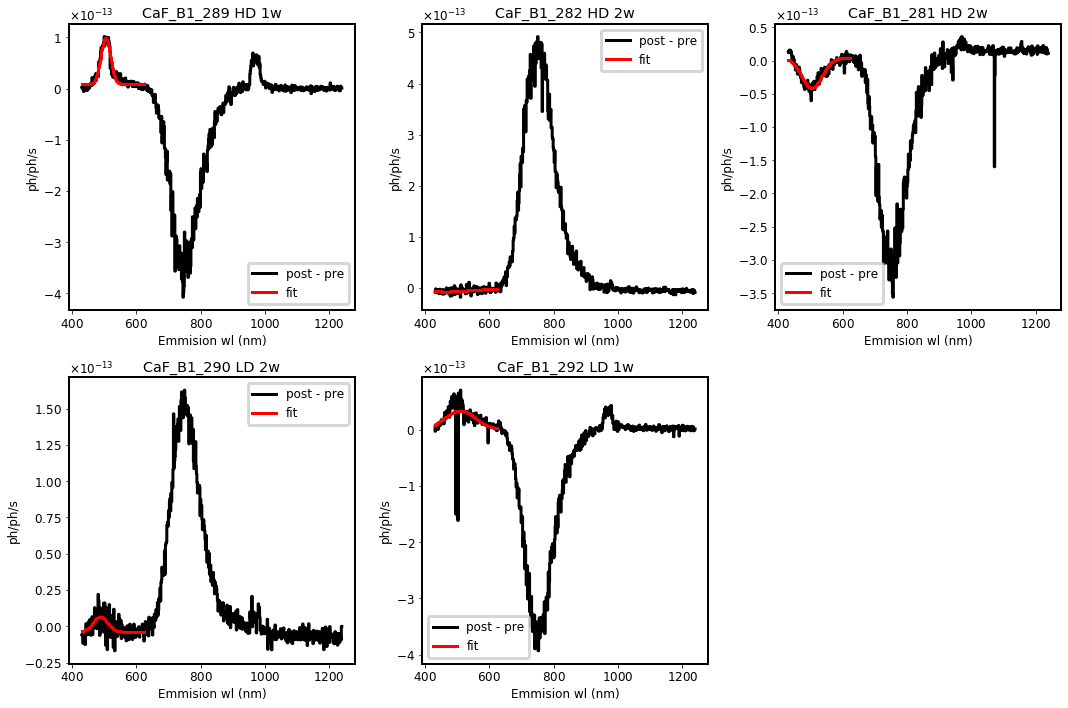

In [15]:
fit_prepost("CaF", ex_wl=400, peak=500, rebin_by=3)
fit_diff   ("CaF", ex_wl=400, peak=500, rebin_by=3)

1 CaF_B1_289 pre  int 2791.4816672682123 peak 39.1132551621074
1 CaF_B1_289 post int 2539.773052084599 peak 35.52178774702915
2 CaF_B1_282 pre  int 2778.6685626495987 peak 39.05938337489825
2 CaF_B1_282 post int 3122.892723303755 peak 43.82890505898645
3 CaF_B1_281 pre  int 2750.3332662413354 peak 38.508010171038585
3 CaF_B1_281 post int 2525.473400851085 peak 35.33255537626538
4 CaF_B1_290 pre  int 56.863419249546844 peak 0.8062393194519043
4 CaF_B1_290 post int 165.54201807773268 peak 2.319322621668148
5 CaF_B1_292 pre  int 1334.629149500577 peak 18.736679869128157
5 CaF_B1_292 post int 1082.40112211374 peak 15.05328789393573
1 CaF_B1_289 diff int -251.7464347682944 peak -3.476523101485323
2 CaF_B1_282 diff int 344.20416562204707 peak 4.6880514922548295
3 CaF_B1_281 diff int -224.88156512710907 peak -3.1224203779407604
4 CaF_B1_290 diff int 108.89199158699168 peak 1.5290418415408447
5 CaF_B1_292 diff int -252.20839877658383 peak -3.6169902008902652


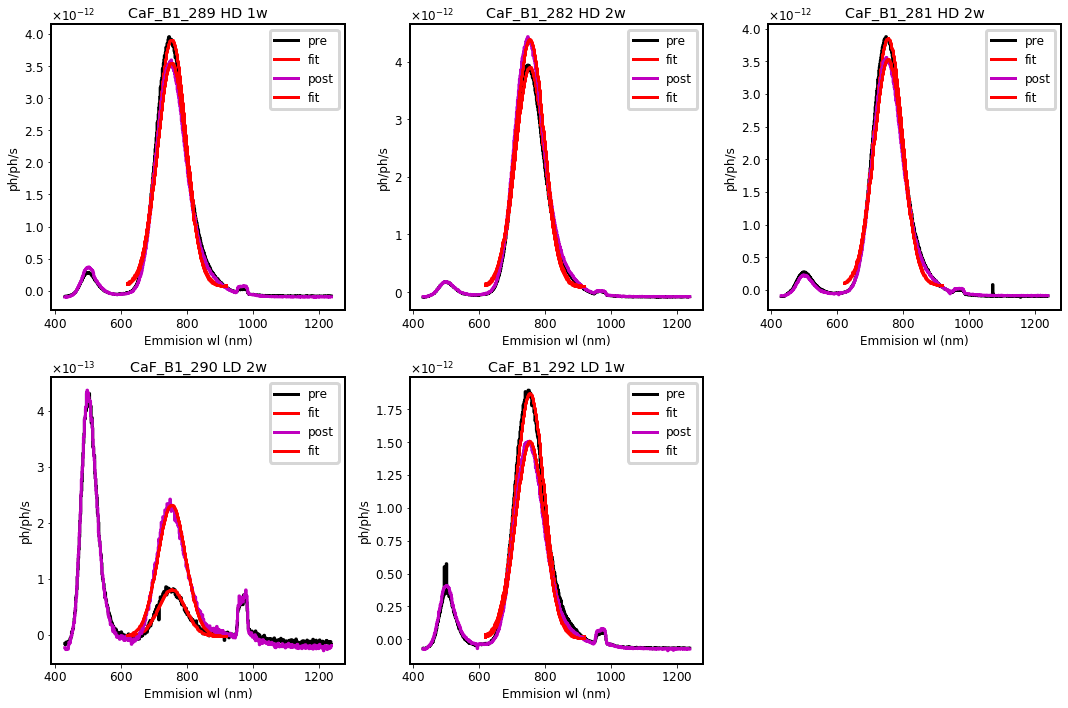

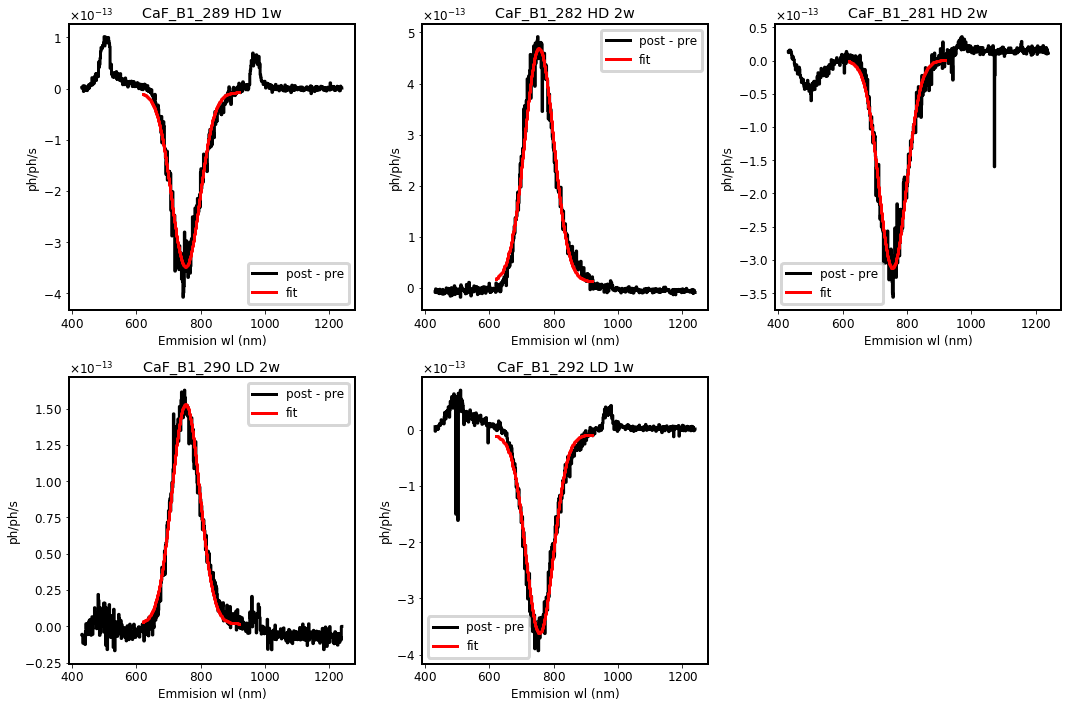

In [16]:
fit_prepost("CaF", ex_wl=400, peak=770, window=150, rebin_by=3)
fit_diff   ("CaF", ex_wl=400, peak=770, window=150, rebin_by=3)

1 CaF_B1_289 pre  int 9183.894404981977 peak 42.10623407572336
1 CaF_B1_289 post int 10671.755007359134 peak 48.81620174773659
2 CaF_B1_282 pre  int 6194.677994903998 peak 28.374342107971838
2 CaF_B1_282 post int 9435.302734669167 peak 43.041409472355774
3 CaF_B1_281 pre  int 7329.97517660325 peak 33.562939711882024
3 CaF_B1_281 post int 9108.87564932818 peak 41.73564774188804
4 CaF_B1_290 pre  int 249.81035147906013 peak 1.160300881427867
4 CaF_B1_290 post int 920.5608104739738 peak 4.312290753775788
5 CaF_B1_292 pre  int 4728.421490203235 peak 21.682785266113154
5 CaF_B1_292 post int 5160.441102585982 peak 23.57152084988007
1 CaF_B1_289 diff int 1488.2162696871962 peak 6.756975110838897
2 CaF_B1_282 diff int 3240.564196580701 peak 14.73833506646186
3 CaF_B1_281 diff int 1778.4211628781009 peak 8.18057912819874
4 CaF_B1_290 diff int 670.7963657798838 peak 3.0710864315436486
5 CaF_B1_292 diff int 432.79567272209067 peak 1.8957912480975592


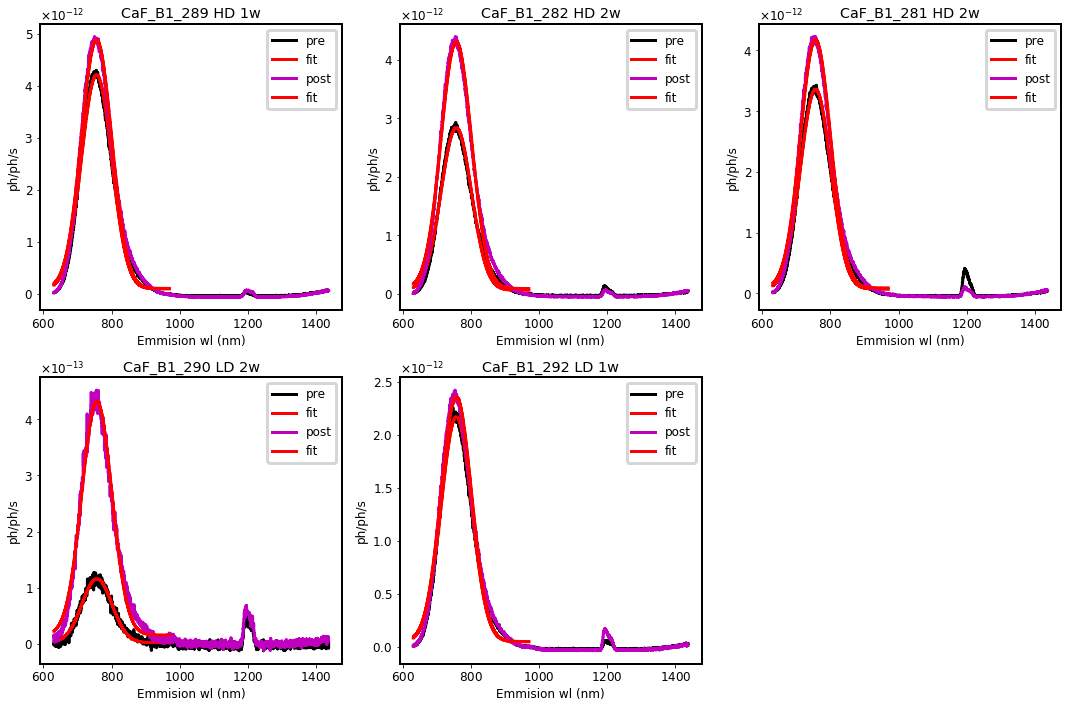

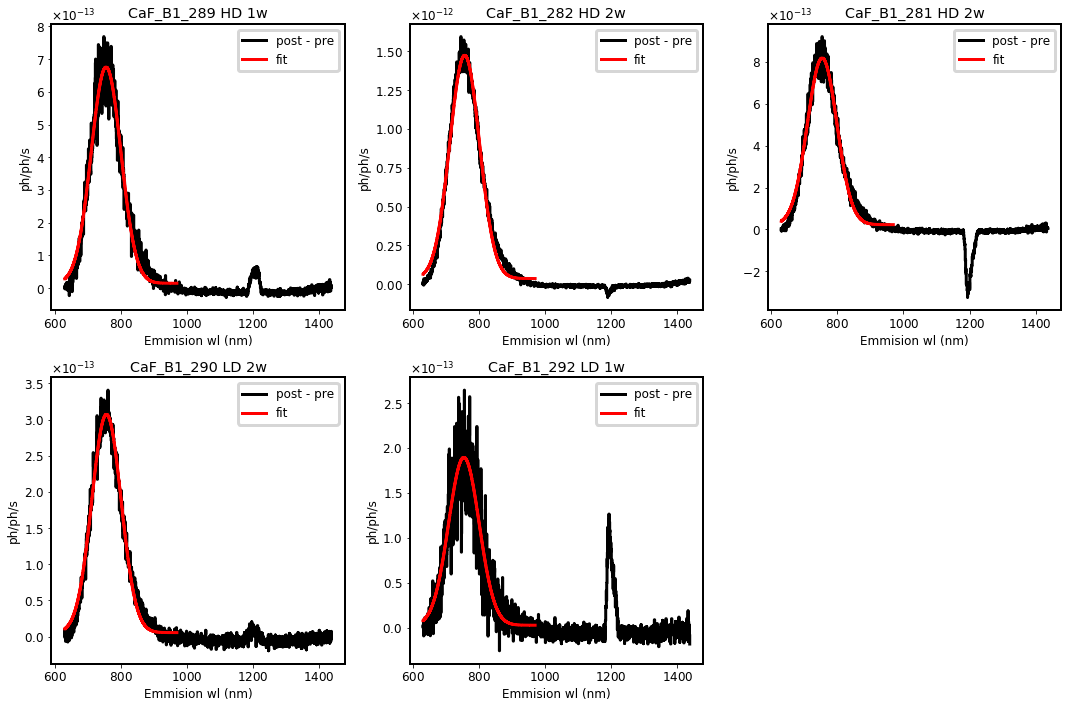

In [23]:
fit_prepost("CaF", ex_wl=600, peak=770, window=200, exposure=1)
fit_diff   ("CaF", ex_wl=600, peak=770, window=200, exposure=1)

1 CaF_B1_289 pre  int 783.8979786858715 peak 3.602836589286224
1 CaF_B1_289 post int 744.1901124520352 peak 3.3982187478657035
2 CaF_B1_282 pre  int 487.31205256000254 peak 2.272167056660704
2 CaF_B1_282 post int 463.209995686383 peak 2.149409980832389
3 CaF_B1_281 pre  int 677.0255034571536 peak 3.1205694803924957
3 CaF_B1_281 post int 546.41320812272 peak 2.542351853782339
4 CaF_B1_290 pre  int 13.621507910604263 peak 0.044815097347168924
4 CaF_B1_290 post int 34.243954579068514 peak 0.1528371076529908
5 CaF_B1_292 pre  int 297.16512969734674 peak 1.360762411369391
5 CaF_B1_292 post int 248.34075848111686 peak 1.1136257226558857
1 CaF_B1_289 diff int -39.495987495426874 peak -0.18619918115841416
2 CaF_B1_282 diff int -24.71568765152675 peak -0.12296717063478065
3 CaF_B1_281 diff int -130.56516101596466 peak -0.5921012820173557
4 CaF_B1_290 diff int 21.342429568100467 peak 0.09213367486362331
5 CaF_B1_292 diff int -11.243778587220028 peak -0.14516241910971764


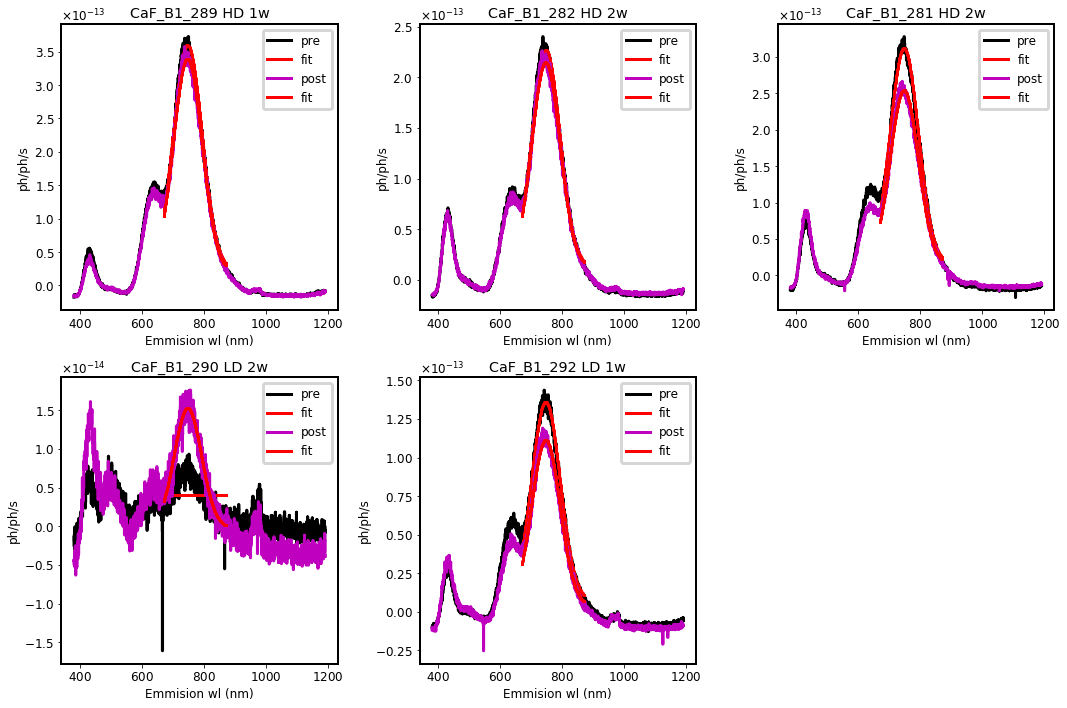

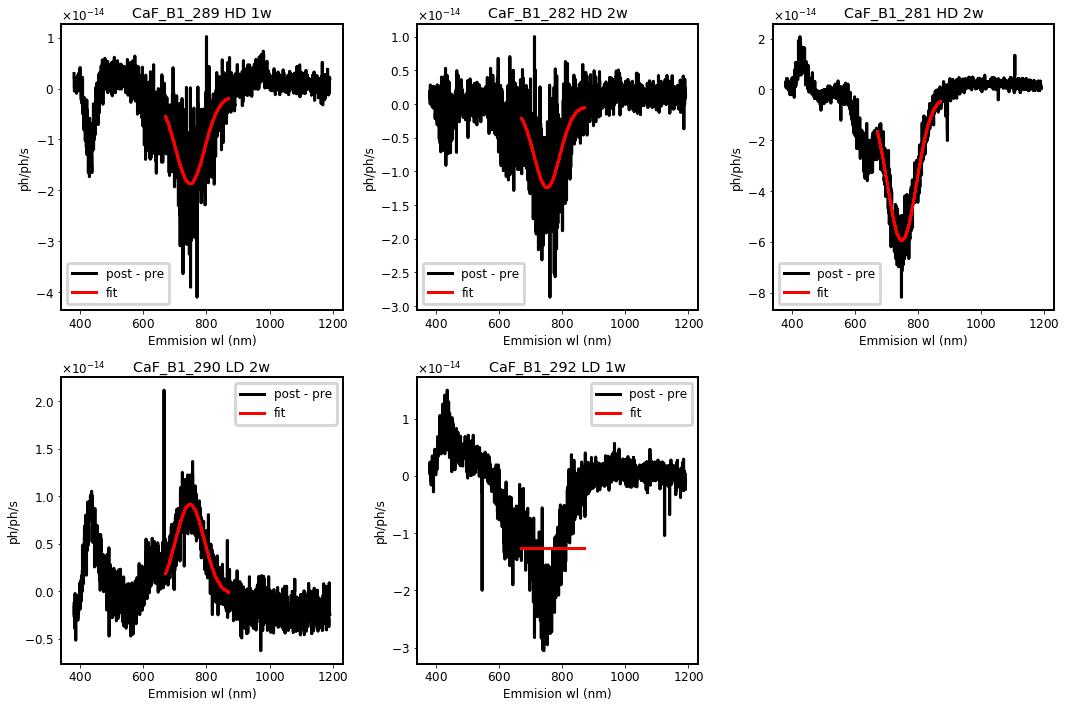

In [18]:
fit_prepost("CaF", ex_wl=350, peak=770, window=100)
fit_diff   ("CaF", ex_wl=350, peak=770, window=100)

1 CaF_B1_289 pre  int 72.0893221280111 peak 1.8421162892090777
1 CaF_B1_289 post int 67.7191531576079 peak 1.7290518191585535
2 CaF_B1_282 pre  int 41.90481919250085 peak 1.0117238671773012
2 CaF_B1_282 post int 1.1319413576046222e+51 peak 1.1594431435725858e+47
3 CaF_B1_281 pre  int 57.54012424171986 peak 1.3628213315715392
3 CaF_B1_281 post int 1.4833237428351688e+52 peak 1.5153410641959626e+48
4 CaF_B1_290 pre  int 5.04360048949227 peak 0.06396147016590521
4 CaF_B1_290 post int 2.441852733277942 peak 0.07933621983990767
5 CaF_B1_292 pre  int 27.5207456999204 peak 1.6918254544009415
5 CaF_B1_292 post int 21.40711723950415 peak 1.1840502834097717
1 CaF_B1_289 diff int 482813.2425494451 peak 0.13895321216373185
2 CaF_B1_282 diff int 367531.6545790164 peak 0.013209585444513798
3 CaF_B1_281 diff int 7220730.287427432 peak 0.07916833422353416
4 CaF_B1_290 diff int 5.995190609060081e+22 peak 8.318402004506779e+18
5 CaF_B1_292 diff int 318745.20215944655 peak 13.431385327424955


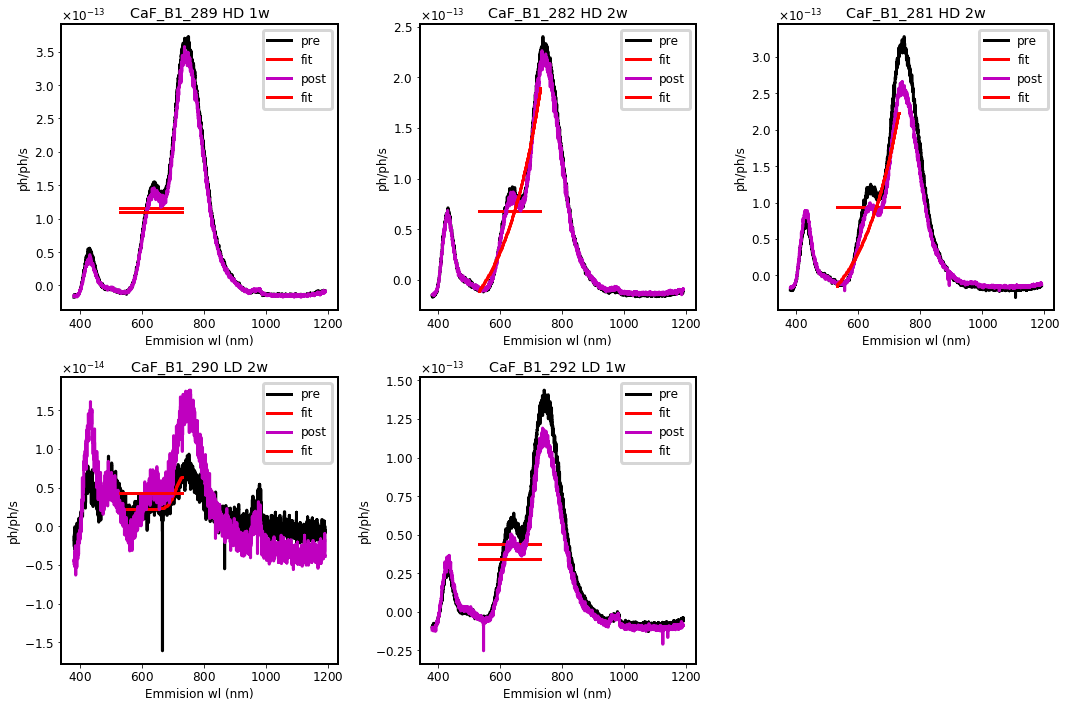

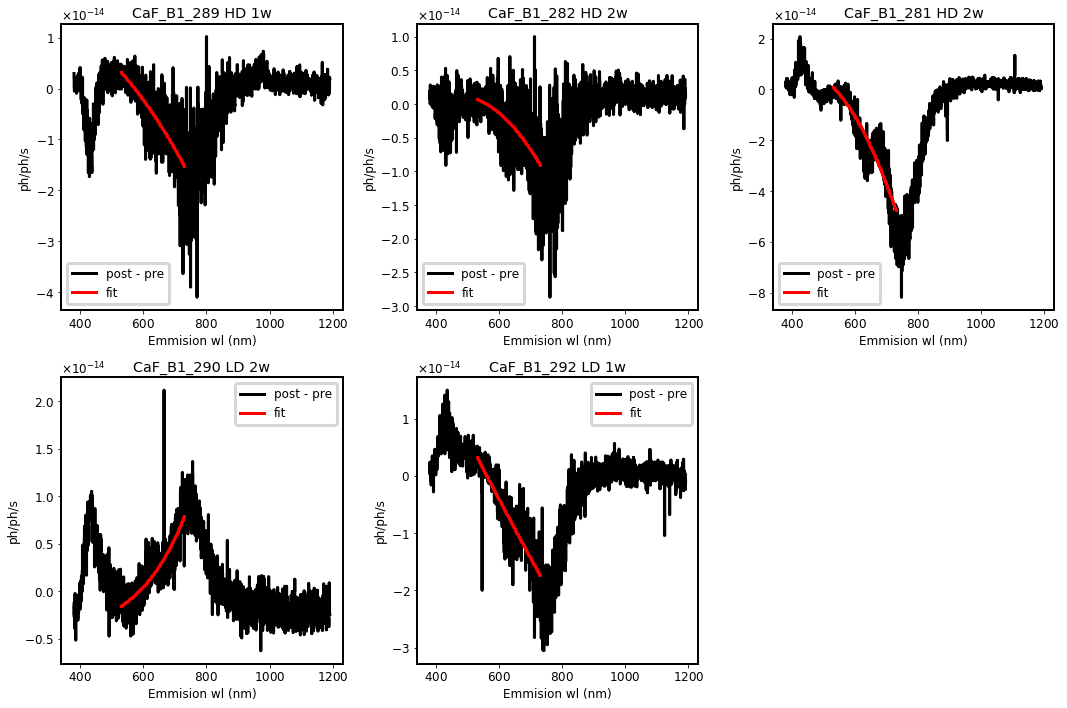

In [19]:
fit_prepost("CaF", ex_wl=350, peak=630, window=100)
fit_diff   ("CaF", ex_wl=350, peak=630, window=100)

1 CaF_B1_289 pre  int 48.39166373130721 peak 0.5215917731925943
1 CaF_B1_289 post int 37.60602469982251 peak 0.3869031493311145
2 CaF_B1_282 pre  int 59.382691129848865 peak 0.6579524879636428
2 CaF_B1_282 post int 56.4664214979393 peak 0.6333677209361693
3 CaF_B1_281 pre  int 67.22189263745317 peak 0.7351730103864661
3 CaF_B1_281 post int 77.59728776515699 peak 0.8657511295400007
4 CaF_B1_290 pre  int 1.4332363842575502 peak 0.0615281065040398
4 CaF_B1_290 post int 8.456450008619127 peak 0.13923675251754306
5 CaF_B1_292 pre  int 23.386731519688812 peak 0.27326870528041375
5 CaF_B1_292 post int 28.737707155073117 peak 0.3340625949916632
1 CaF_B1_289 diff int -10.938572252655835 peak -0.11520781369874199
2 CaF_B1_282 diff int -2.7616507027015995 peak -0.025999632489025634
3 CaF_B1_281 diff int 10.374512997981638 peak 0.11704561840165655
4 CaF_B1_290 diff int 8.920407260773231 peak 0.0827697110152077
5 CaF_B1_292 diff int 6.434334845101653 peak 0.0830579481978558


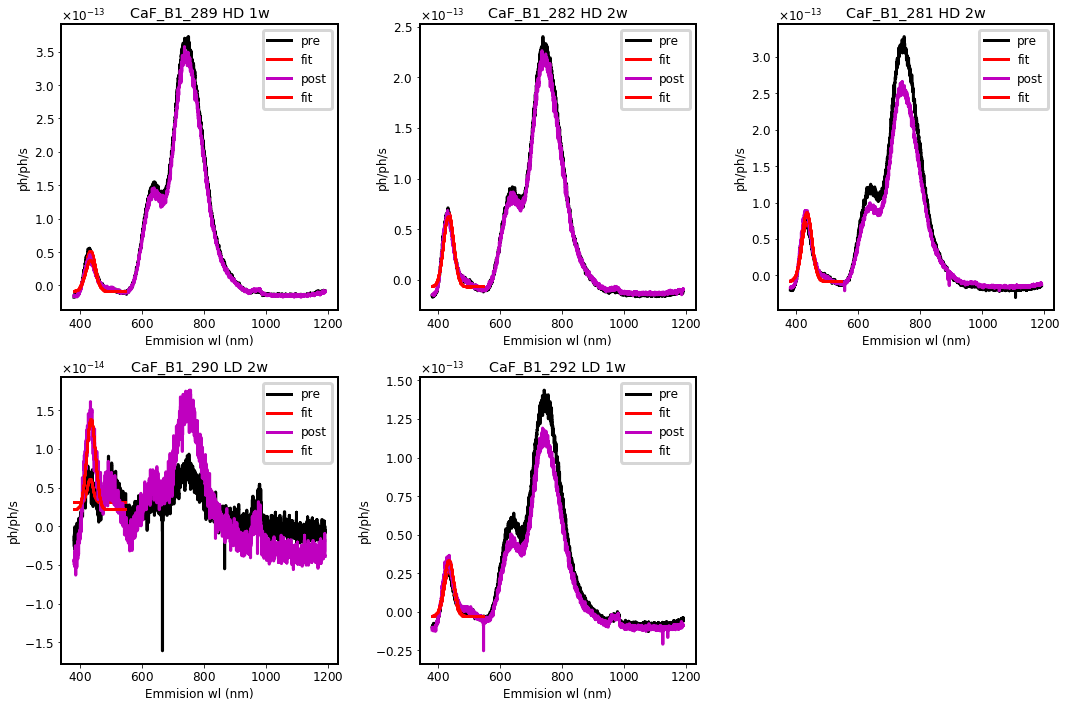

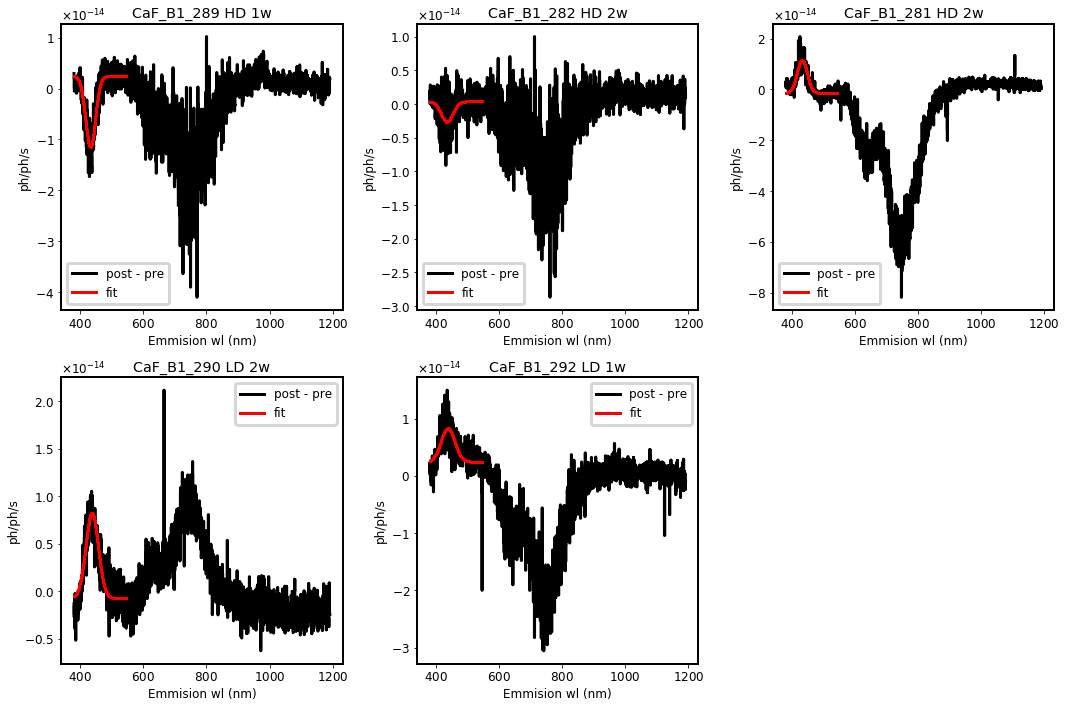

In [20]:
fit_prepost("CaF", ex_wl=350, peak=420)
fit_diff   ("CaF", ex_wl=350, peak=420)